# Big Ideas in CS Final Project
# Team Plumber Pandas - Group 22

# Introduction

You are a plumber, right out of trade school, looking to concur the big wide world. You want to venture out and start your own private plumber practice. But there's one problem... you're not sure where to go. You know that leaving Pittsburgh is out of the question, you grew up here and love the culture, weather and delicious fish fry. So that leads you to the question: what is the best neighborhood in Pittsburgh to be a plumber? 
![chris pratt mario](https://i.kym-cdn.com/entries/icons/original/000/042/185/l-intro-1655761181.jpeg)

For our metric, we chose the datasets of Pittsburgh census employment data, public water facilities, and fish fry locations. We believe these three things are essential in the quest to start up as a successful plumber in Pittsburgh. First, knowing where the most plumbers are will help you get a head start in areas without much competition, leading to lots of potential growth. Second, knowing where the most water faciltiies, specifically drinking fountains are. On a hot summer day the worst thing you can run into is a broken water fountain, so living in an area with lots of water features to work on will be great for business. Lastly, you can't forgot the comforts of the area, and after a hard day's work you'll definetly build up an appetite, so its important to know if a plumber can get a fish fry where you're going. Combining all these metrics, we can score the values and plug them into a formula to ultimately determine the best place to be a Pittsburgh plumber.

In [14]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, LineString, Point
from matplotlib import pyplot as plt
import math
plt.style.use('bmh')

## First dataset: Where are the plumbers?

In [16]:
# import DataFrame
dataPlumbers = pd.read_csv("plumbers_employment.csv")

# make data usable for calculation
for neighborhood in dataPlumbers.index:
    population = int(dataPlumbers.iloc[neighborhood,2].replace(',', ''))
    percentPlumbers = str(dataPlumbers.iloc[neighborhood,7]).replace('%','')
    # perform calculation using population and percent of utility workers
    numPlumb = float(population) * (float(percentPlumbers)/100)
    # rewrite existing percentage as number of workers
    dataPlumbers.iloc[neighborhood,7] = numPlumb

# redefine dataframe to drop out all irrelevant columns
dataPlumbers.rename(columns = {"Resident Jobs: Transportation, warehousing, utilities":"Plumbers"}, inplace=True)
dataPlumbers = dataPlumbers[["Neighborhood","Plumbers"]]
dataPlumbers.head(10)


,Neighborhood,Plumbers
0,Allegheny Center,0.0
1,Allegheny West,67.452
2,Allentown,140.0
3,Arlington,33.642
4,Arlington Heights,0.0
5,Banksville,78.736
6,Bedford Dwellings,147.846
7,Beechview,223.272
8,Beltzhoover,204.05
9,Bloomfield,151.956


Text(0, 0.5, 'Neighborhood')

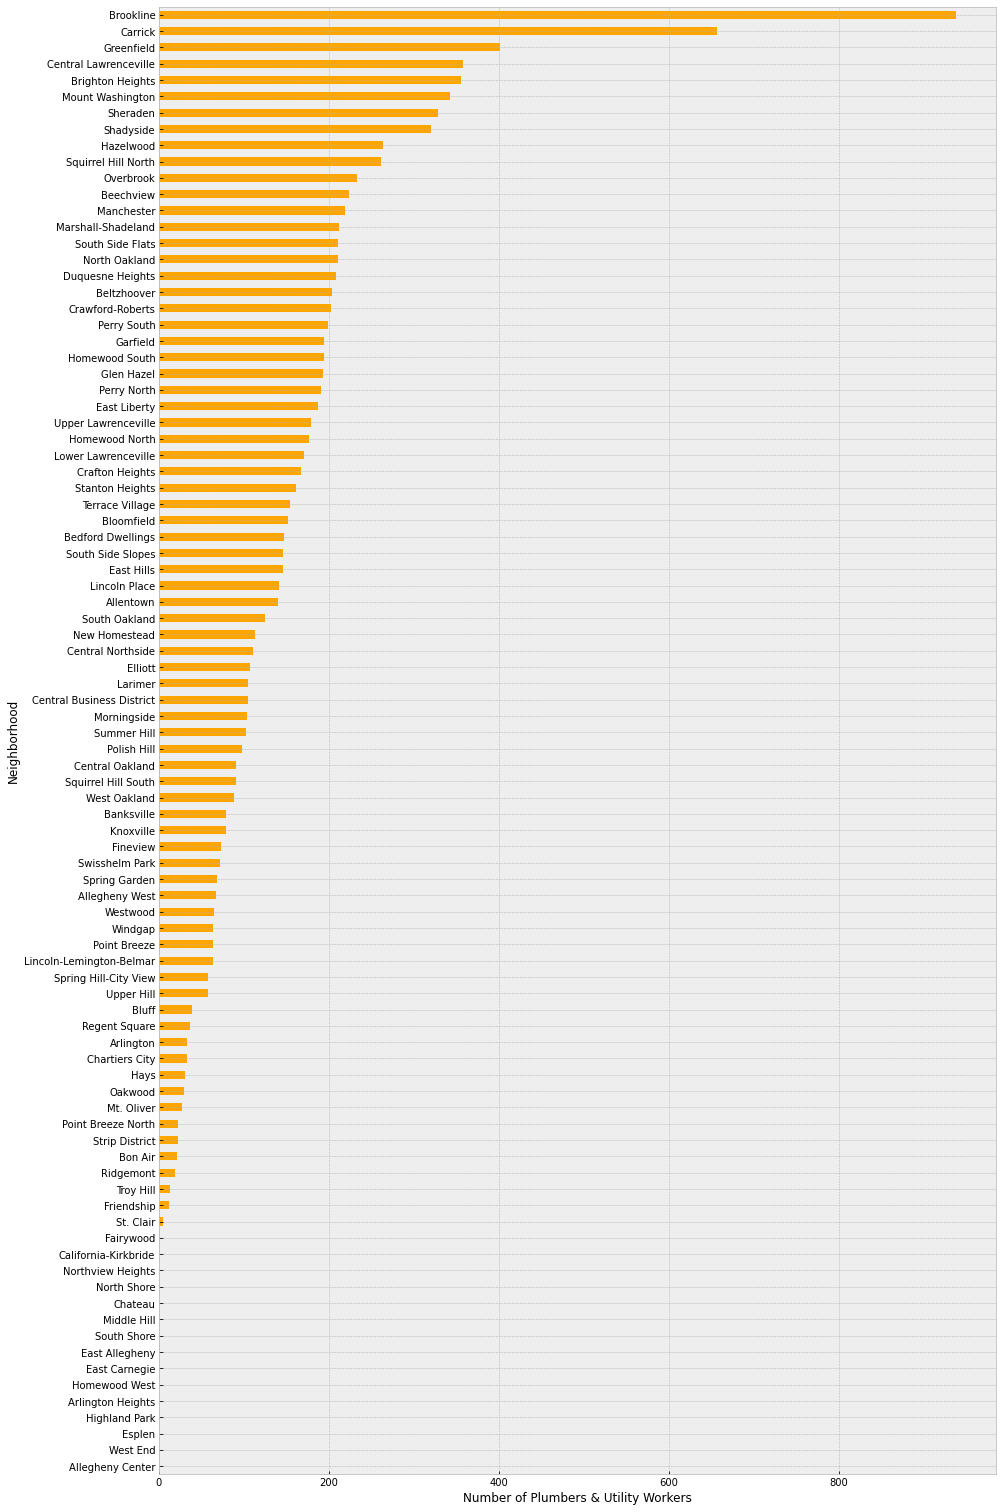

In [17]:
# graphing the DataFrame
dataPlumbers = dataPlumbers.sort_values(by=["Plumbers"], ascending=True)
neighborhoods = dataPlumbers['Neighborhood']
dataPlumbers = dataPlumbers.set_index("Neighborhood")

graph = dataPlumbers.plot.barh(figsize=(15,dataPlumbers.shape[0] * 0.3), legend=None, color=['orange'])
graph.set_xlabel("Number of Plumbers & Utility Workers")
graph.set_ylabel("Neighborhood")

## Second dataset: Where can I find a water fountain?

In [18]:
dataPublicRestrooms = pd.read_csv('https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170')

# import water features data
dataFountains = pd.read_csv("water-features.csv")

row_count = 0

#delete every row that is not a water fountain
for index, row in dataFountains.iterrows():
    if str(row[3]) != "Drinking Fountain":
        dataFountains = dataFountains.drop(labels=row_count, axis=0)
    row_count += 1

dataFountains.head()


,id,name,control_type,feature_type,inactive,make,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1816791851,Able Long Park,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Beechview,4,19,42003192000,5,19,6,4-28,40.408440,-80.028330
1,1599892422,Albert Turk Graham Park,On/Off,Drinking Fountain,f,Most Dependable,https://tools.wprdc.org/images/pittsburgh/wate...,Crawford-Roberts,6,3,42003030500,3,3,2,2-1,40.440453,-79.984064
2,1422043278,Allegheny Commons Arch St,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.454390,-80.008281
3,1237191582,Allegheny Commons East Tennis Courts,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-6,40.450874,-80.001962
4,1146184773,Allegheny Commons Pool,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-6,40.451003,-80.001502


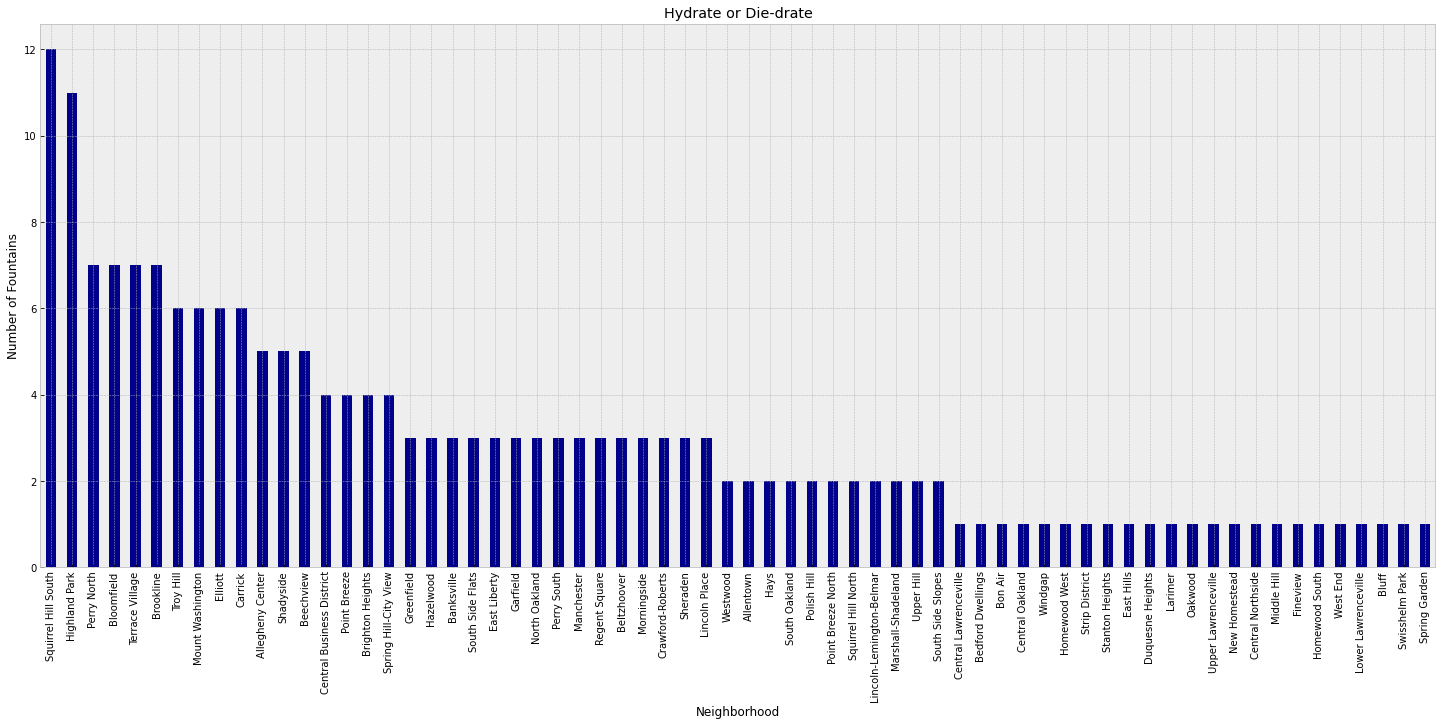

In [19]:
# sort list by neighborhood count, which will show num of fountains
numFountains = dataFountains['neighborhood'].value_counts().sort_values(ascending=False)

# graphing the DataFrame
numFountains.plot(kind="bar",figsize=(25,10),color='#00008B',ylabel="Number of Fountains",xlabel="Neighborhood",title="Hydrate or Die-drate")

## Third dataset: Fish fry

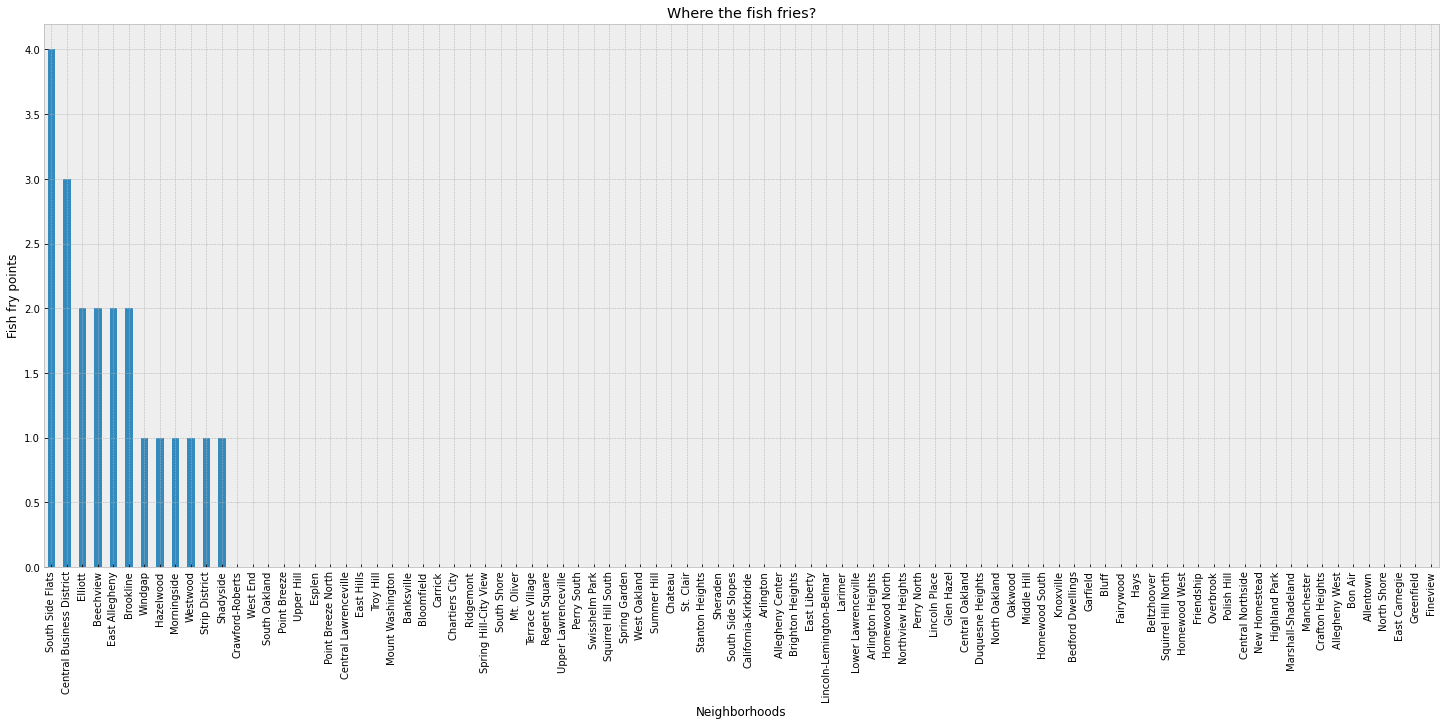

In [23]:
fishFryData = pd.read_csv('fishfry.csv')

frypoints = dict()
lunchpoints = dict()
geoneighbor = gp.read_file('neighborhood.json')

# use geospatial data to determine fish fry location using latitude and longitude
gs = gp.GeoDataFrame(geoneighbor)

count = 0
for p in gs.geometry:
    n = geoneighbor['hood'][count]
    if n not in frypoints:
        frypoints[n] = 0.0
        lunchpoints[n] = 0.0
    count+=1

for i,r in fishFryData.iterrows():
    lalo = Point(r['longitude'], r['latitude'])
    count = 0
    for p in gs.geometry:
        tf = lalo.within(p)
        if tf:
            n = geoneighbor['hood'][count]
            if r['lunch']:
                lunchpoints[n] += 1.0
            frypoints[n] += 1.0
            break
        count+=1
        
# sort fish fry data
fryd = pd.Series(frypoints)
fryd = fryd.sort_values(ascending=False)
lunchd = pd.Series(lunchpoints)
lunchd = lunchd.sort_values(ascending=False)

# plot data for all fish fry locations
fryd.plot(kind='bar', ylabel="Fish fry points", xlabel="Neighborhoods", title="Where the fish fries?",figsize=(25,10))


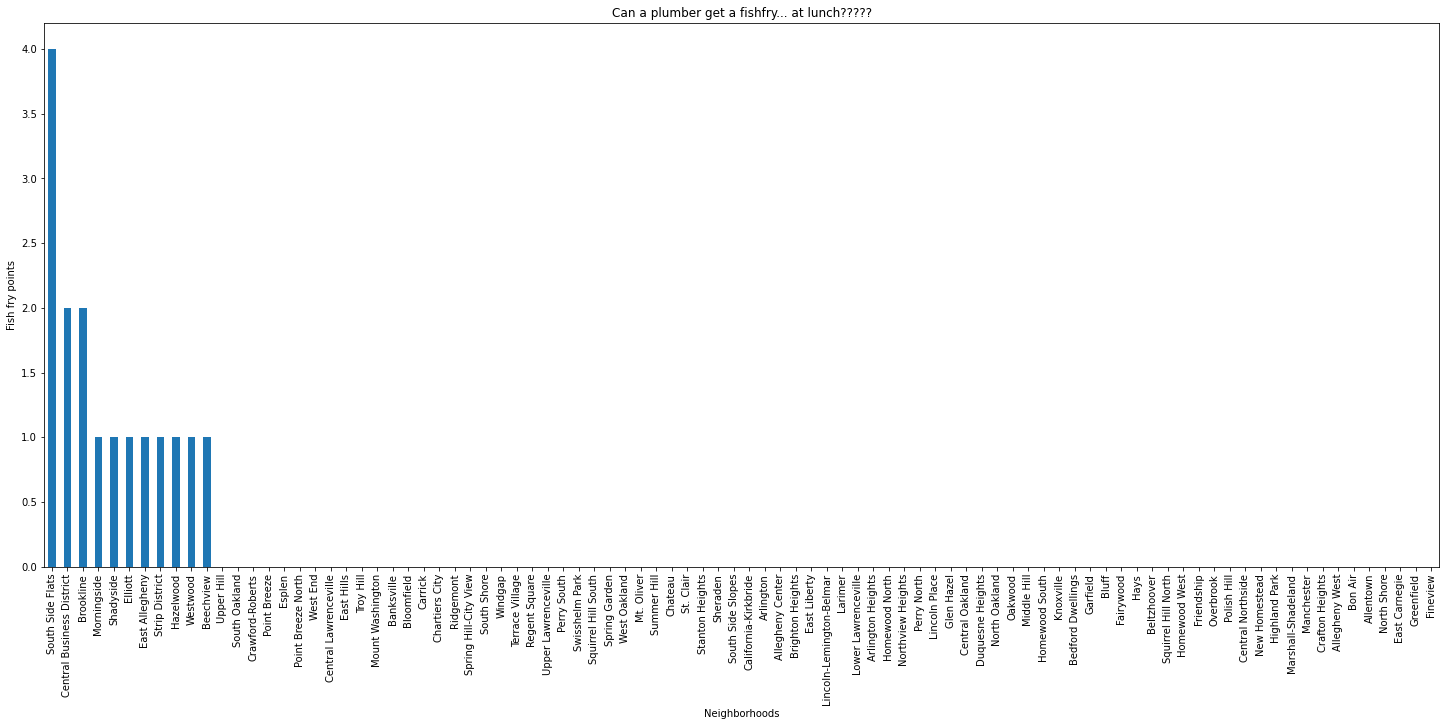

In [7]:
# plot data for fish fry locations open during lunch hours
lunchd.plot(kind='bar', ylabel="Fish fry points", xlabel="Neighborhoods", title="Can a plumber get a fishfry... at lunch?????",figsize=(25,10))

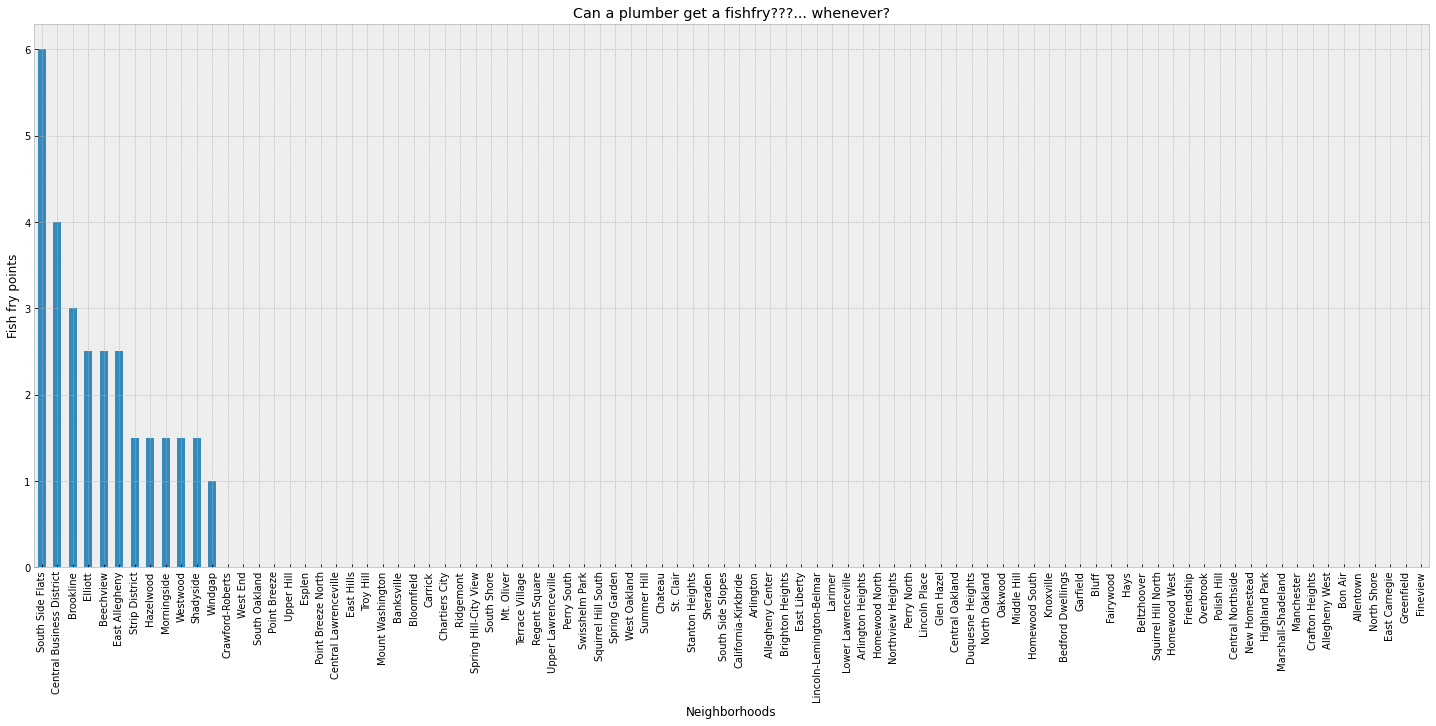

In [21]:
for i in frypoints:
    frypoints[i] += lunchpoints[i] * .5
fryd = pd.Series(frypoints)
fryd = fryd.sort_values(ascending=False)
fryd.plot(kind='bar', ylabel="Fish fry points", xlabel="Neighborhoods", title="Can a plumber get a fishfry???... whenever?",figsize=(25,10))

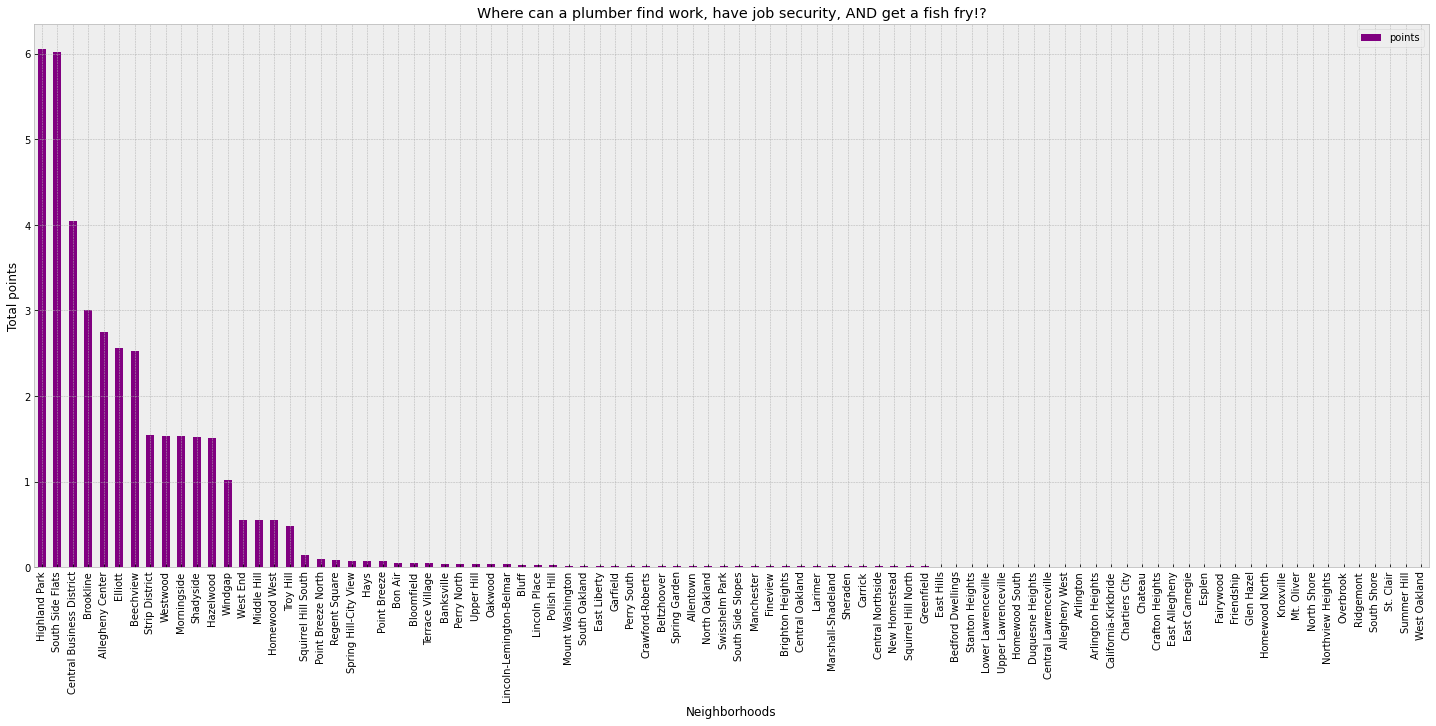

In [22]:
# convert series to dataframes, and use a mask to ensure non-zero values
fryframe = fryd.to_frame()
fouframe = numFountains.to_frame()
fryframe.columns = ["points"]
fouframe.columns = ["points"]
dataPlumbers.columns = ["points"]
finalplum = dataPlumbers.mask(dataPlumbers["points"] < 1.0, other=2.0)

# use formula to calculate total points based on weighting
points = fouframe * 1.1 / finalplum
points += fryframe

# plot total points
points = points.sort_values(by="points", ascending=False)
points.plot(kind="bar", ylabel="Total points", xlabel="Neighborhoods", title="Where can a plumber find work, have job security, AND get a fish fry!?", figsize=(25,10), color='purple')

# Conclusion

From this data, we can conclude that Highland Park is the best neighborhood in Pittsburgh for a plumber to live, with lots of steady employment from the public fountains that might break down, however considering the importance of fish fry, the runner ups of South Side Flats and Central Business District are also great places for a plumber to set up shop. This final metric calculation was somewhat skewed by the large disparity in the plumbers population dataset, and this allowed certain neighborhoods to be weighted quite highly. 

Freddie: I am suprised, solely because neither town leading has good job securty or fishfry locations. Personally I love squirrel hill, it is just great to relax. Sadly there is no fish fry.

Imran: This result based on our three metrics was interesting but not extremely shocking given that it incorporates data from a wide range of sources on vastly different scales. My own favorite neighborhood is actually the South Side Flats, number 2 on our overall ranking, because it is home to Victory Pointe arcade, a place where I've made a lot of fun memories.